In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from scipy.stats import norm
import statsmodels.api as sm
from mpl_toolkits import mplot3d
pd.options.display.float_format = '{:,.0f}'.format

In [2]:
# Data Importing
prices = pd.read_excel('./Downloads/Supra prices.xlsx')

sales = []
for path in glob.glob('./Downloads/*sales.xlsx'):
    df = pd.read_excel(path)
    sales.append(df)
sales = pd.concat(sales)

orderbook = []
for path in glob.glob('./Downloads/*orderbook.xlsx'):
    df = pd.read_excel(path)
    orderbook.append(df)
orderbook = pd.concat(orderbook)

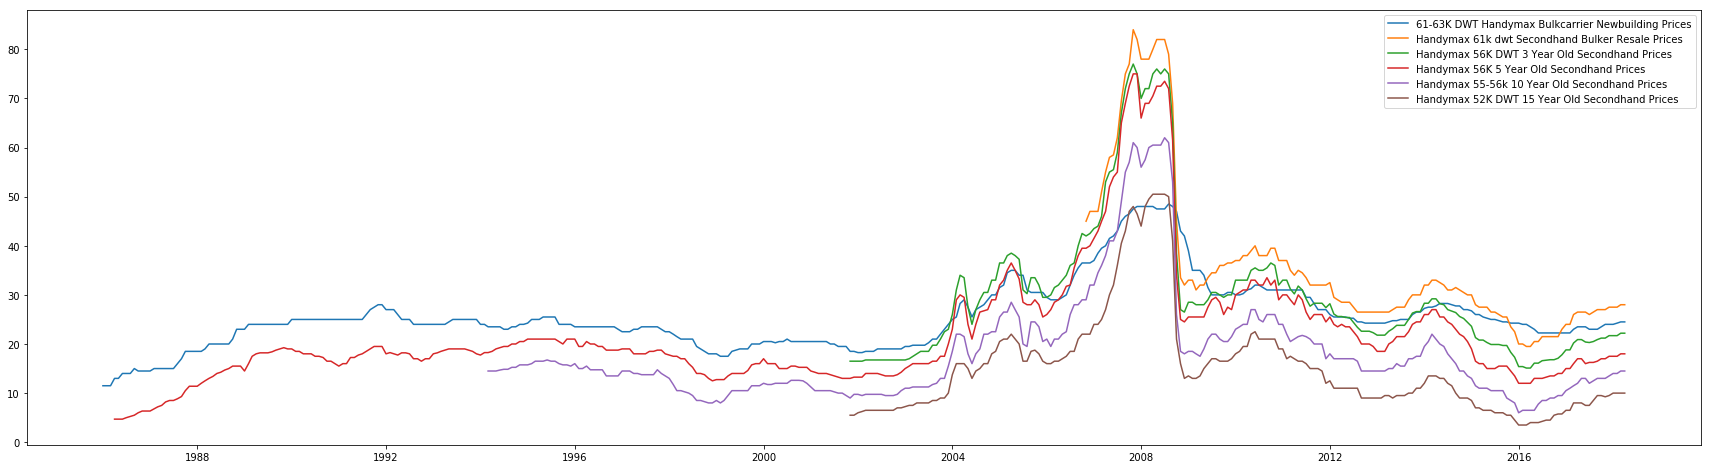

In [3]:
# Time Series of New Building Prices
plt.figure(figsize=(30,8))
plt.plot(prices['Date'], prices['61-63K DWT Handymax Bulkcarrier Newbuilding Prices'])
plt.plot(prices['Date'], prices['Handymax 61k dwt Secondhand Bulker Resale Prices'])
plt.plot(prices['Date'], prices['Handymax 56K DWT 3 Year Old Secondhand Prices'])
plt.plot(prices['Date'], prices['Handymax 56K 5 Year Old Secondhand Prices'])
plt.plot(prices['Date'], prices['Handymax 55-56k 10 Year Old Secondhand Prices'])
plt.plot(prices['Date'], prices['Handymax 52K DWT 15 Year Old Secondhand Prices'])
prices.columns = ['Date','NB','Resale','3y','5y','10y','15y']
plt.legend()
plt.show()

Mean : 0.227%
Std : 2.499%


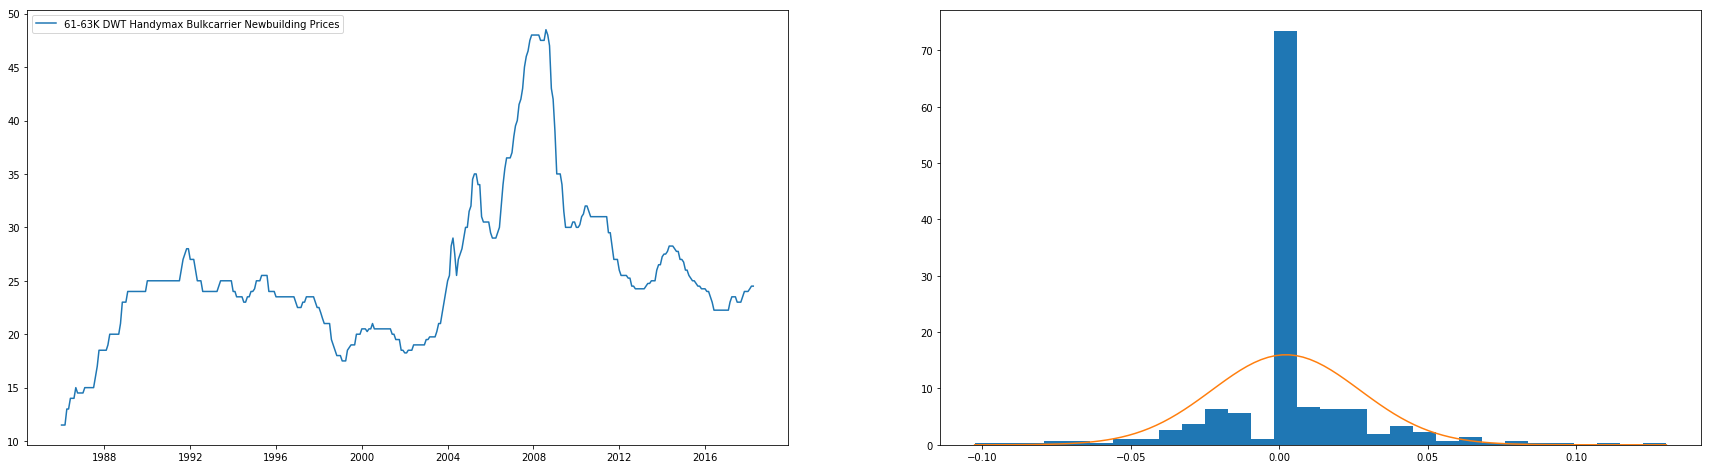

In [4]:
# Increases of Newbuilding Prices
price_ts = prices.loc[~prices['NB'].isna() ,'NB']
rate = (price_ts.shift(1)/price_ts-1)[1:]
x = np.linspace(rate.min(), rate.max(), 100)
mu, sigma = norm.fit(rate)
print('Mean : {:.3%}\nStd : {:.3%}'.format(rate.mean(), rate.std()))

fig, ax = plt.subplots(1,2,figsize=(30,8))
ax[0].plot(prices['Date'], prices['NB'], label='61-63K DWT Handymax Bulkcarrier Newbuilding Prices')
ax[1].hist(rate, bins=30, normed=True)
ax[1].plot(x, norm.pdf(x, loc=mu, scale=sigma))
ax[0].legend()
plt.show()

Mean : 0.272%
Std : 6.995%


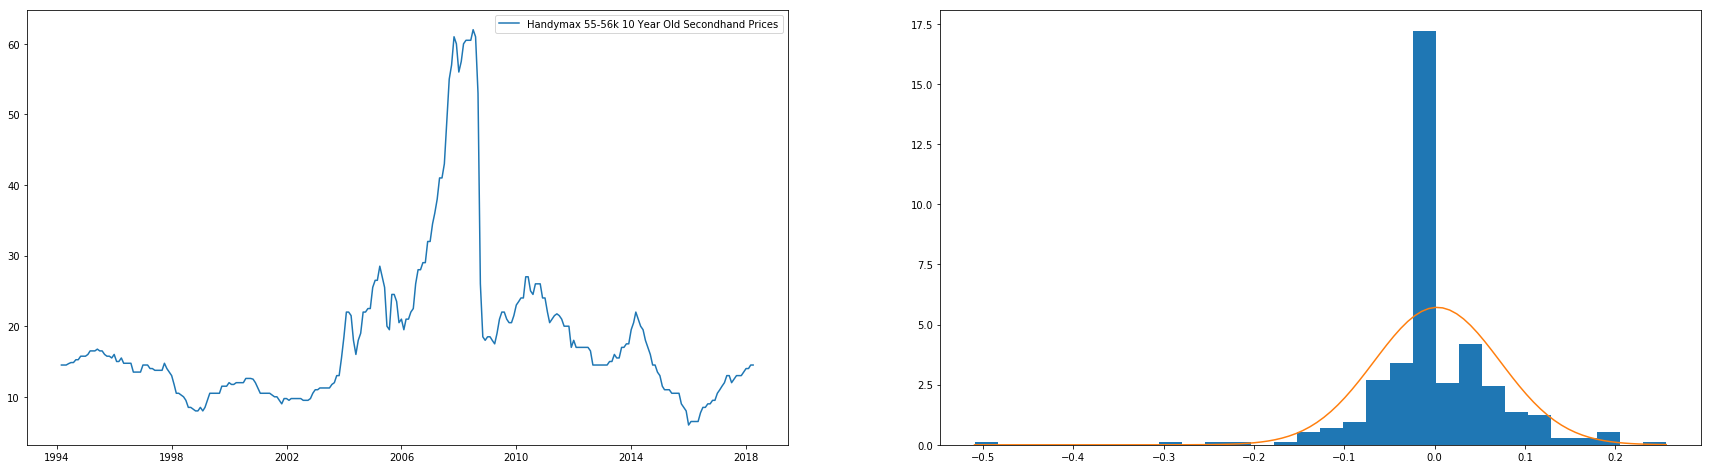

In [5]:
# Increases of 10 Year Old Secondhand Prices
price_ts = prices.loc[~prices['10y'].isna() ,'10y']
rate = (price_ts.shift(1)/price_ts-1)[1:]
x = np.linspace(rate.min(), rate.max(), 100)
mu, sigma = norm.fit(rate)
print('Mean : {:.3%}\nStd : {:.3%}'.format(rate.mean(), rate.std()))

fig, ax = plt.subplots(1,2,figsize=(30,8))
ax[0].plot(prices['Date'], prices['10y'], label='Handymax 55-56k 10 Year Old Secondhand Prices')
ax[1].hist(rate, bins=30, normed=True)
ax[1].plot(x, norm.pdf(x, loc=mu, scale=sigma))
ax[0].legend()
plt.show()

In [6]:
# Preprocessing
sales = sales[~sales['Price'].isna()]
sales['Sold_yr'] = sales['Sold'].apply(lambda date:date.year)
sales['Sold_mn'] = sales['Sold'].apply(lambda date:date.month)
sales.eval('Age = Sold_yr - Built', inplace=True)

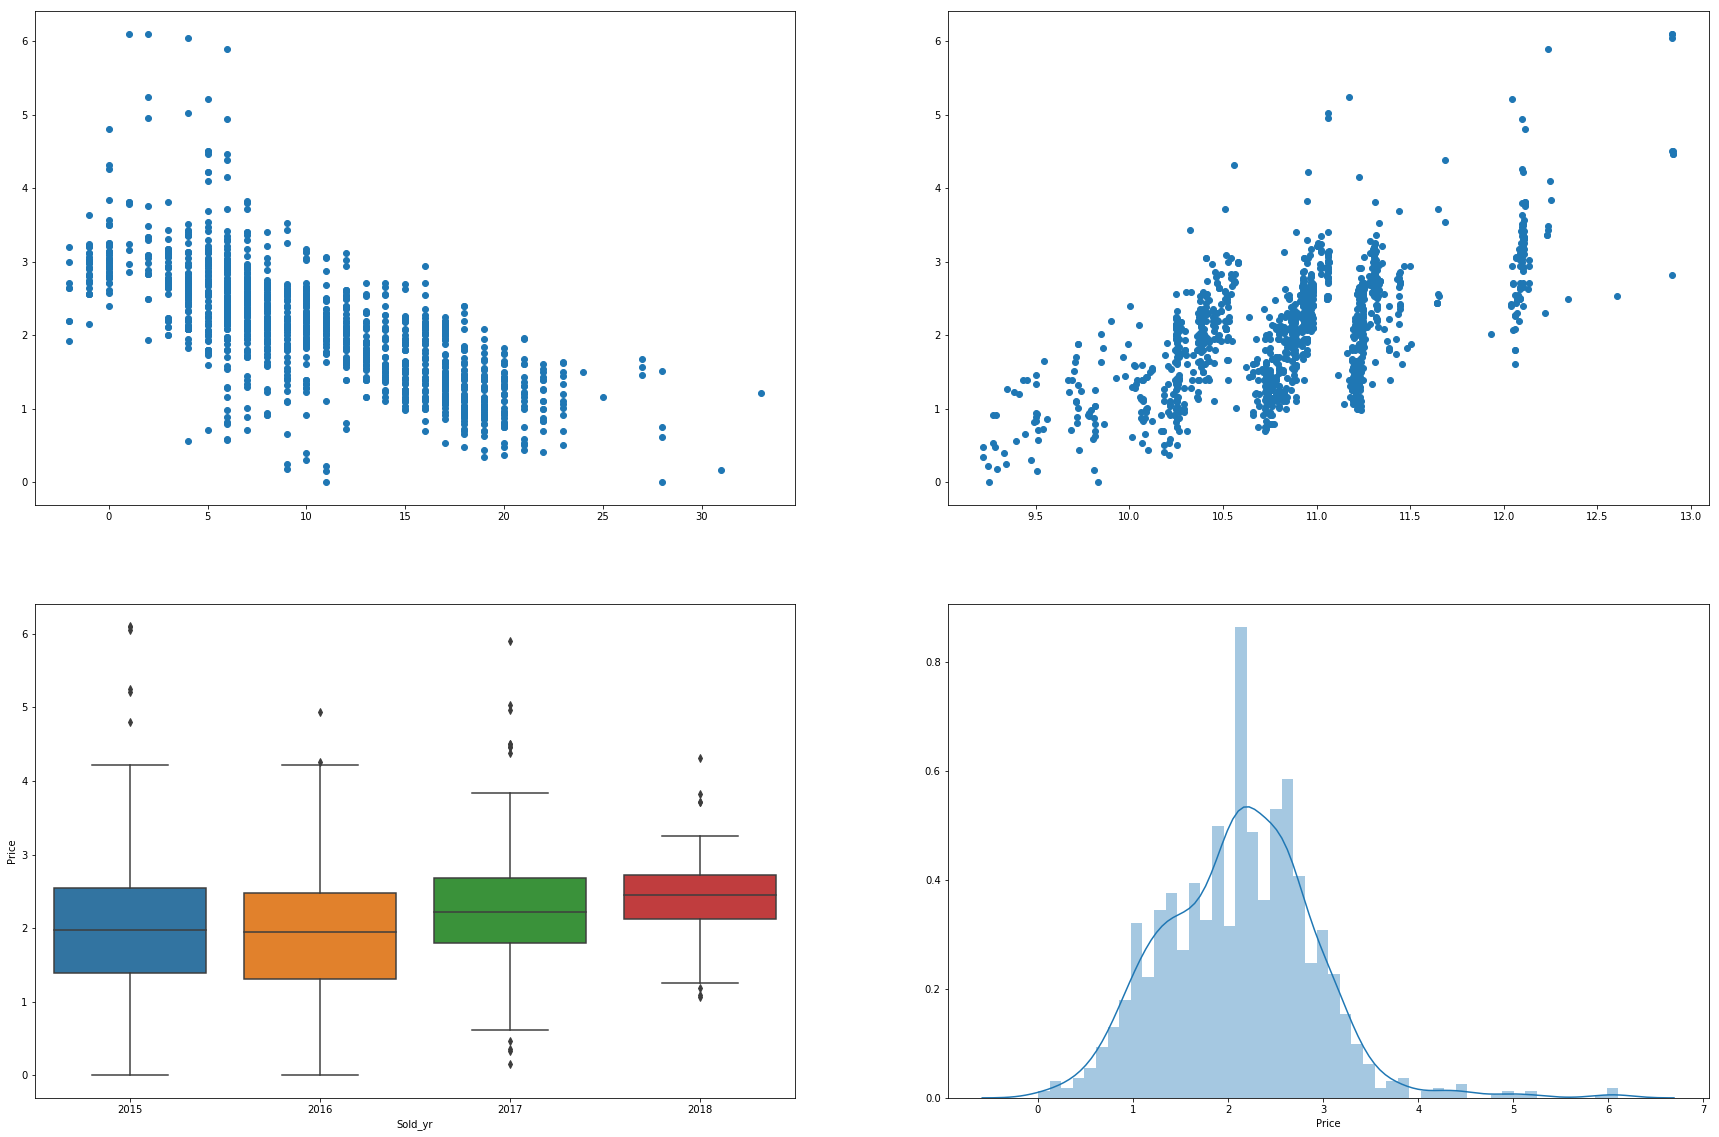

In [112]:
# Bulkcarrier Prices
fig, ax = plt.subplots(2,2,figsize=(30,20))
ax[0][0].scatter(sales['Age'], np.log(sales['Price']))
ax[0][1].scatter(np.log(sales['Dwt']), np.log(sales['Price']))
sns.boxplot(x=sales['Sold_yr'], y=np.log(sales['Price']), ax=ax[1][0])
sns.distplot(np.log(sales['Price']), bins=50, ax=ax[1][1])
plt.show()

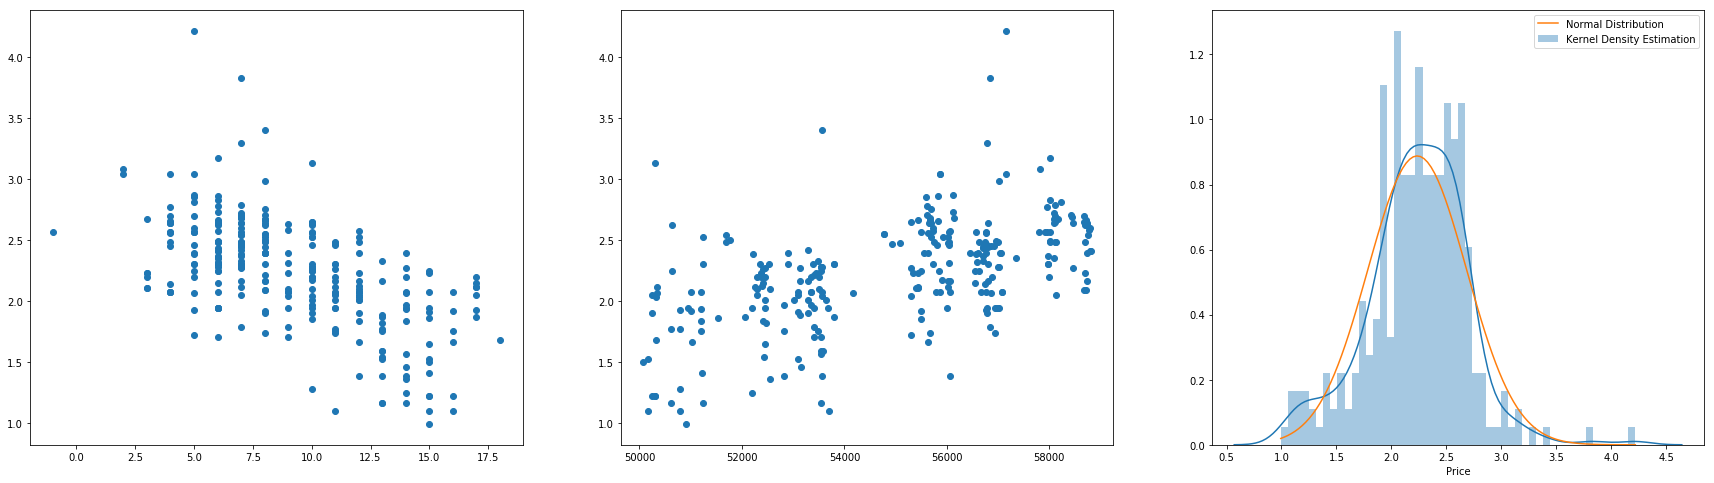

In [8]:
# Bulkcarrier Prices (50,000 < DWT < 60,000)
supramax = sales.query('Dwt > 50000 and Dwt < 60000')
data = np.log(supramax['Price'])
x = np.linspace(data.min(), data.max(), 100)
mu, sigma = norm.fit(data)

fig, ax = plt.subplots(1,3,figsize=(30,8))
ax[0].scatter(supramax['Age'], np.log(supramax['Price']))
ax[1].scatter(supramax['Dwt'], np.log(supramax['Price']))
sns.distplot(np.log(supramax['Price']), bins=50, ax=ax[2], label='Kernel Density Estimation')
ax[2].plot(x, norm.pdf(x, loc=mu, scale=sigma), label='Normal Distribution')
ax[2].legend()
plt.show()

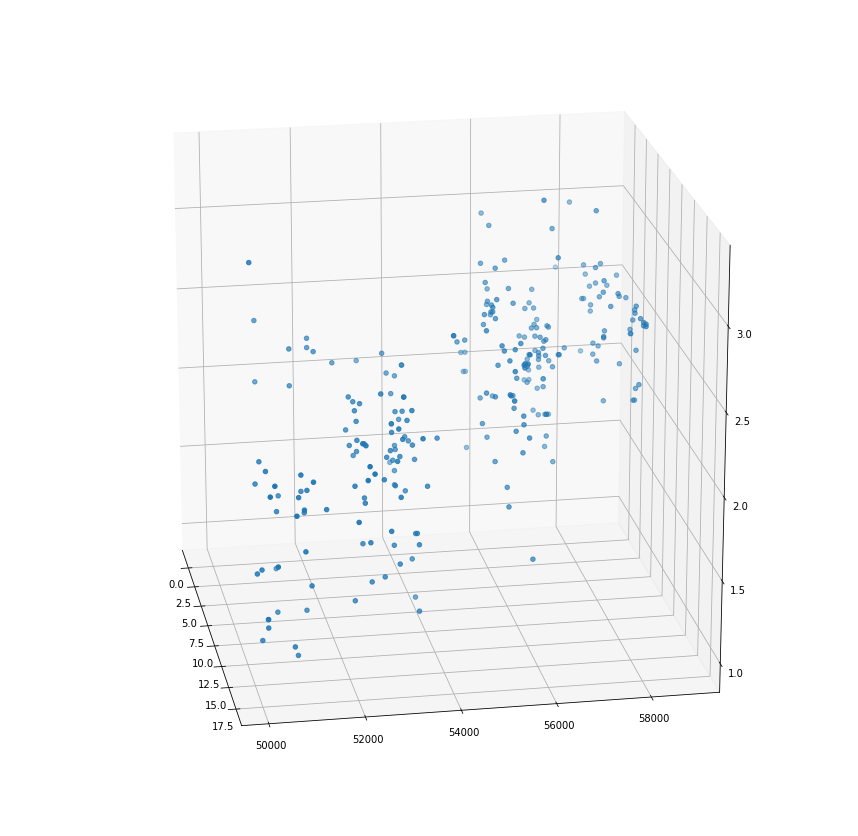

In [44]:
# 3D plot
tmp = supramax[supramax['Price'] < 29]
plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.view_init(20, -10)
ax.scatter(tmp['Age'], tmp['Dwt'], np.log(tmp['Price']), cmap='viridis')
plt.show()

Expected Depreciation (3 Yrs) : -12.0%
Standard Error : 11.1%
Frequency : 37.1%
Severity : 5.8%
Loss : 2.2%


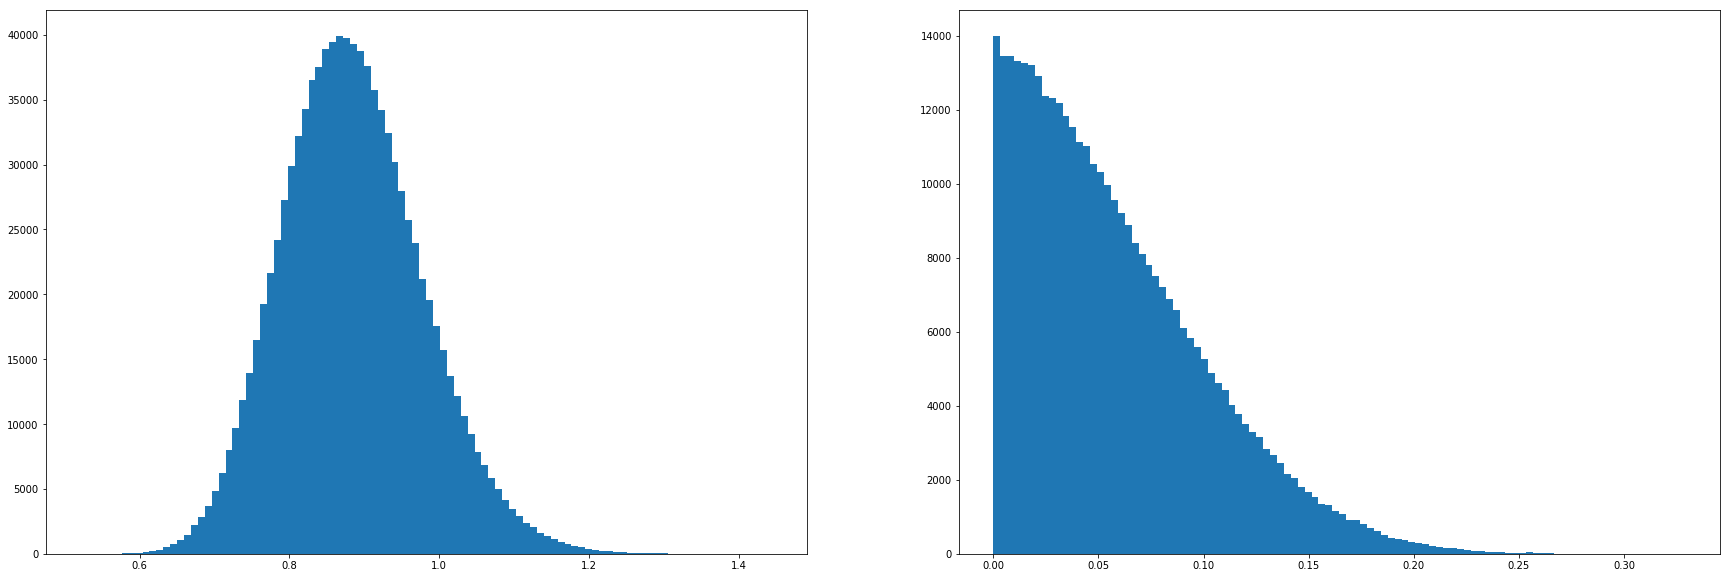

In [295]:
# OLS (1)
X = tmp[['Dwt','Age']]
y = np.log(tmp['Price'])
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()
se = model.scale

print('Expected Depreciation (3 Yrs) : {:.1%}'.format(np.exp(3*model.params['Age'])-1))
print('Standard Error : {:.1%}'.format(np.exp(se)-1))

fig, ax = plt.subplots(1,2,figsize=(30,10))

n = 1000000
resid = np.exp(norm(3*model.params['Age'],se).rvs(n))
claims = np.fmax(0.85 - resid,0)

print('Frequency : {:.1%}'.format(len(claims[claims>0])/len(claims)))
print('Severity : {:.1%}'.format(np.mean(claims[claims>0])))
print('Loss : {:.1%}'.format(np.mean(claims)))

ax[0].hist(resid, bins=100)
ax[1].hist(claims[claims>0], bins=100)
plt.show()

Expected 11 Year Old Secondhand Price : 9.4M USD
Standard Error : 11.1%
Frequency : 72.0%
Severity : 1.0M USD
Loss : 0.7M USD


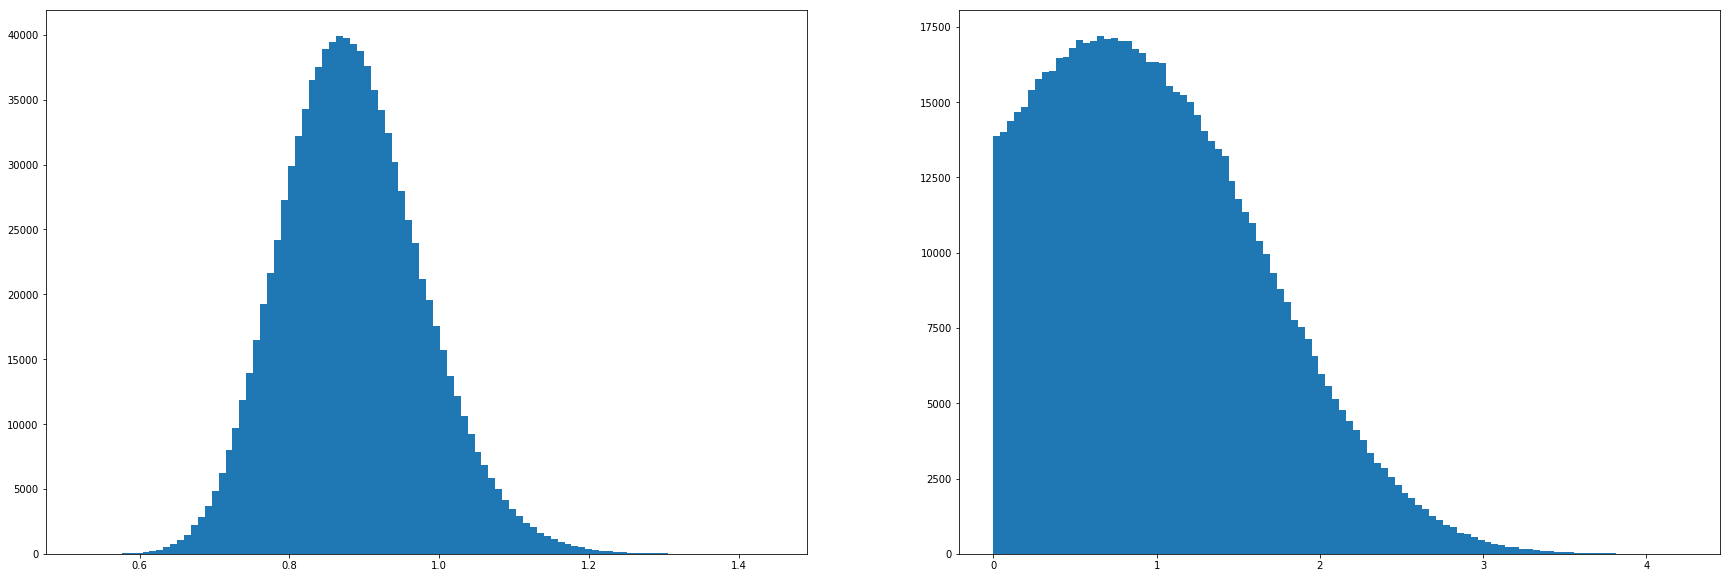

In [307]:
# OLS (2)
X = tmp[['Dwt','Age']]
y = np.log(tmp['Price'])
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()
se = model.scale

print('Expected 11 Year Old Secondhand Price : {:,.1f}M USD'.format(np.exp(model.predict([1,57000,11]))[0]))
print('Standard Error : {:.1%}'.format(np.exp(se)-1))

fig, ax = plt.subplots(1,2,figsize=(30,10))

n = 1000000
covered = 10
resid_value = np.exp(norm(model.predict([1,57000,11]),se).rvs(n))
claims = np.fmax(covered-resid_value,0)

print('Frequency : {:.1%}'.format(len(claims[claims>0])/len(claims)))
print('Severity : {:.1f}M USD'.format(np.mean(claims[claims>0])))
print('Loss : {:.1f}M USD'.format(np.mean(claims)))

ax[0].hist(resid, bins=100)
ax[1].hist(claims[claims>0], bins=100)
plt.show()